Import & Load Data

In [3]:
import pandas as pd
import numpy as np

file_path = r"C:\projects\SCMS_Delivery_History_Dataset.csv"

df = pd.read_csv(file_path)

df.head()




,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


Dataset Info & Missing Values

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [5]:
df.isna().sum()


ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

Parse Date Columns

In [38]:
date_cols = [
    "PQ First Sent to Client Date",
    "PO Sent to Vendor Date",
    "Scheduled Delivery Date",
    "Delivered to Client Date",
    "Delivery Recorded Date",
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[date_cols].head()


,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date
0,NaT,NaT,2006-06-02,2006-06-02,2006-06-02
1,NaT,NaT,2006-11-14,2006-11-14,2006-11-14
2,NaT,NaT,2006-08-27,2006-08-27,2006-08-27
3,NaT,NaT,2006-09-01,2006-09-01,2006-09-01
4,NaT,NaT,2006-08-11,2006-08-11,2006-08-11


Keep Rows With Key Dates Only

In [39]:
df = df.dropna(subset=["Scheduled Delivery Date", "Delivered to Client Date"]).copy()
df.shape


(10324, 39)

Create Derived Time Columns

In [40]:
# lead_time_days: الفرق بين Delivered و PO Sent
if "PO Sent to Vendor Date" in df.columns:
    df["lead_time_days"] = (
        df["Delivered to Client Date"] - df["PO Sent to Vendor Date"]
    ).dt.days
else:
    df["lead_time_days"] = np.nan

# delay_days: الفرق بين Delivered و Scheduled
df["delay_days"] = (
    df["Delivered to Client Date"] - df["Scheduled Delivery Date"]
).dt.days

# تحويل لأرقام
df["lead_time_days"] = pd.to_numeric(df["lead_time_days"], errors="coerce")
df["delay_days"] = pd.to_numeric(df["delay_days"], errors="coerce")

# تنظيف القيم الشاذة
# lead_time_days: نشيل أقل من 0 (غير منطقي) وأكبر من 365 يوم
df.loc[df["lead_time_days"] < 0, "lead_time_days"] = np.nan
df.loc[df["lead_time_days"] > 365, "lead_time_days"] = np.nan

# delay_days: نسمح بالقيم السالبة (تسليم مبكر) لكن نحدها
df.loc[df["delay_days"] > 365, "delay_days"] = np.nan
df.loc[df["delay_days"] < -90, "delay_days"] = np.nan

# is_late بعد التنظيف
df["is_late"] = (df["delay_days"] > 0).astype(int)

# year / month / year_month من تاريخ التسليم
df["year"] = df["Delivered to Client Date"].dt.year
df["month"] = df["Delivered to Client Date"].dt.month
df["year_month"] = df["Delivered to Client Date"].dt.to_period("M").astype(str)

df[["lead_time_days", "delay_days", "is_late", "year", "month", "year_month"]].head()



,lead_time_days,delay_days,is_late,year,month,year_month
0,NaN,0.0,0,2006,6,2006-06
1,NaN,0.0,0,2006,11,2006-11
2,NaN,0.0,0,2006,8,2006-08
3,NaN,0.0,0,2006,9,2006-09
4,NaN,0.0,0,2006,8,2006-08


Clean Numeric Columns & Fill Missing

In [75]:
# Step 6 — Clean Numeric Columns Including Weight

numeric_cols = [
    "Freight Cost (USD)",
    "Line Item Insurance (USD)",
    "Weight (Kilograms)",
    "Line Item Quantity",
    "Line Item Value",
    "Pack Price",
    "Unit Price",
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

weight_col = "Weight (Kilograms)"

if weight_col in df.columns:
    df = df[df[weight_col] > 0].copy()
    
    weight_cap = df[weight_col].quantile(0.95)
    

    df.loc[df[weight_col] > weight_cap, weight_col] = weight_cap


In [70]:
df["lead_time_days"] = pd.to_numeric(df["lead_time_days"], errors="coerce")
df["delay_days"] = pd.to_numeric(df["delay_days"], errors="coerce")

print(df[["lead_time_days", "delay_days"]].describe())

df.loc[df["lead_time_days"] > 365, "lead_time_days"] = np.nan
df.loc[df["delay_days"] > 365, "delay_days"] = np.nan
df.loc[df["delay_days"] < -90, "delay_days"] = np.nan

print(df[["lead_time_days", "delay_days"]].describe())


       lead_time_days    delay_days
count     4557.000000  10100.000000
mean       103.572745     -3.294455
std         74.446826     19.259934
min          0.000000    -89.000000
25%         50.000000     -1.000000
50%         91.000000      0.000000
75%        142.000000      0.000000
max        365.000000    192.000000
       lead_time_days    delay_days
count     4557.000000  10100.000000
mean       103.572745     -3.294455
std         74.446826     19.259934
min          0.000000    -89.000000
25%         50.000000     -1.000000
50%         91.000000      0.000000
75%        142.000000      0.000000
max        365.000000    192.000000


Global KPIs Summary

In [43]:
total_shipments = len(df)
late_shipments = int(df["is_late"].sum())
late_ratio = round((late_shipments / total_shipments) * 100, 2)

avg_lead = round(df["lead_time_days"].mean(), 2)
avg_delay = round(df["delay_days"].mean(), 2)

total_freight_cost = df["Freight Cost (USD)"].sum() if "Freight Cost (USD)" in df.columns else None
total_value = df["Line Item Value"].sum() if "Line Item Value" in df.columns else None

print("Total Shipments:", total_shipments)
print("Late Shipments:", late_shipments)
print("Late Ratio:", late_ratio, "%")
print("Average Lead Time (days):", avg_lead)
print("Average Delay (days):", avg_delay)
print("Total Freight Cost:", total_freight_cost)
print("Total Line Item Value:", total_value)


Total Shipments: 10324
Late Shipments: 1186
Late Ratio: 11.49 %
Average Lead Time (days): 103.57
Average Delay (days): -3.29
Total Freight Cost: 93036045.94000001
Total Line Item Value: 1627584457.29


Country-Level Analysis

In [44]:
country_stats = (
    df.groupby("Country")
    .agg(
        total_shipments=("is_late", "count"),
        late_shipments=("is_late", "sum"),
        avg_lead=("lead_time_days", "mean"),
        avg_delay=("delay_days", "mean"),
        total_quantity=("Line Item Quantity", "sum"),
        total_value=("Line Item Value", "sum"),
    )
    .reset_index()
)

country_stats["late_ratio"] = round(
    (country_stats["late_shipments"] / country_stats["total_shipments"]) * 100, 2
)

country_stats.sort_values("total_shipments", ascending=False).head(10)


,Country,total_shipments,late_shipments,avg_lead,avg_delay,total_quantity,total_value,late_ratio
33,South Africa,1406,115,88.605106,-1.365608,22995781,1.086701e+08,8.18
28,Nigeria,1194,142,93.930041,-8.421459,33967950,3.502721e+08,11.89
9,Côte d'Ivoire,1083,134,117.592437,-3.841566,11898572,1.208845e+08,12.37
39,Uganda,779,98,87.325000,-6.675291,11914117,9.619734e+07,12.58
40,Vietnam,688,6,126.065185,-0.144105,7104544,5.697441e+07,0.87
41,Zambia,683,108,110.576000,-3.682021,28627539,2.469888e+08,15.81
16,Haiti,655,62,111.296296,-1.837174,5225980,4.350279e+07,9.47
26,Mozambique,631,116,117.088710,-0.992063,19252134,1.820247e+08,18.38
42,Zimbabwe,538,77,128.519231,-4.786561,17407714,1.044400e+08,14.31
37,Tanzania,519,66,108.105769,-2.762183,12482994,1.294595e+08,12.72


Shipment Mode Analysis

In [45]:
shipment_stats = (
    df.groupby("Shipment Mode")
    .agg(
        total_shipments=("is_late", "count"),
        late_shipments=("is_late", "sum"),
        avg_lead=("lead_time_days", "mean"),
        avg_delay=("delay_days", "mean"),
    )
    .reset_index()
)

shipment_stats["late_ratio"] = round(
    (shipment_stats["late_shipments"] / shipment_stats["total_shipments"]) * 100, 2
)

shipment_stats


,Shipment Mode,total_shipments,late_shipments,avg_lead,avg_delay,late_ratio
0,Air,6113,587,108.695483,-1.796342,9.60
1,Air Charter,650,75,80.944444,-15.164274,11.54
2,Ocean,371,65,175.571429,5.870620,17.52
3,Truck,2830,455,53.074873,-5.396849,16.08


Monthly Aggregation

In [48]:
monthly_stats = (
    df.groupby("year_month")
    .agg(
        total_shipments=("is_late", "count"),
        late_shipments=("is_late", "sum"),
        total_quantity=("Line Item Quantity", "sum"),
        total_value=("Line Item Value", "sum"),
        avg_lead=("lead_time_days", "mean"),
    )
    .reset_index()
)

monthly_stats["late_ratio"] = round(
    (monthly_stats["late_shipments"] / monthly_stats["total_shipments"]) * 100, 2
)

monthly_stats.head()


,year_month,total_shipments,late_shipments,total_quantity,total_value,avg_lead,late_ratio
0,2006-05,2,0,75,2109.70,NaN,0.0
1,2006-06,2,0,166,11627.45,69.0,0.0
2,2006-07,3,0,50506,129900.00,NaN,0.0
3,2006-08,6,0,94019,692401.00,NaN,0.0
4,2006-09,18,0,85948,1033271.96,NaN,0.0


In [50]:
import matplotlib.pyplot as plt


Top 10 Countries by Quantity

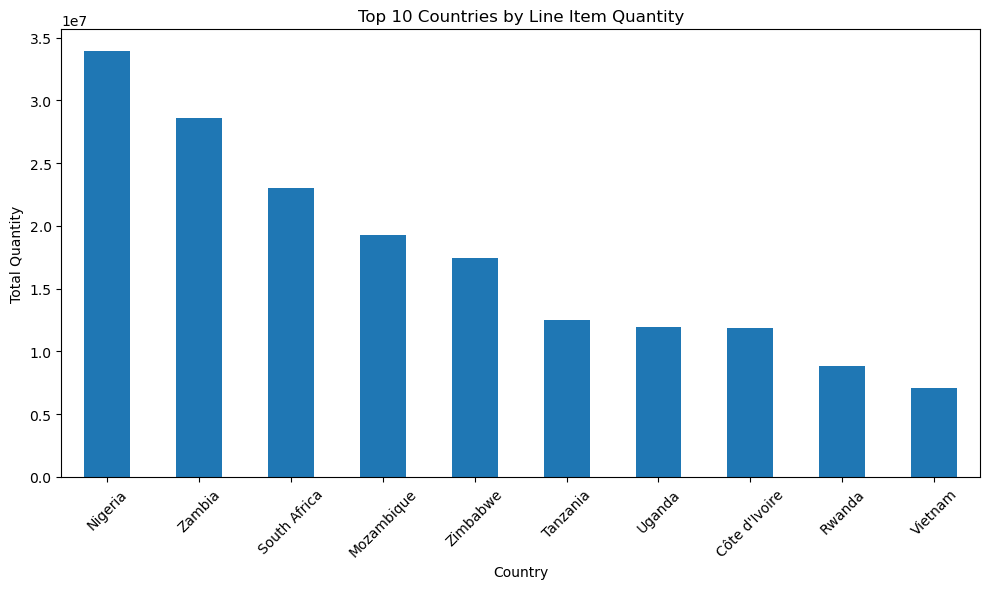

In [51]:
top_countries = (
    df.groupby("Country")["Line Item Quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
top_countries.plot(kind="bar")
plt.title("Top 10 Countries by Line Item Quantity")
plt.xlabel("Country")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Late Ratio by Shipment Mode

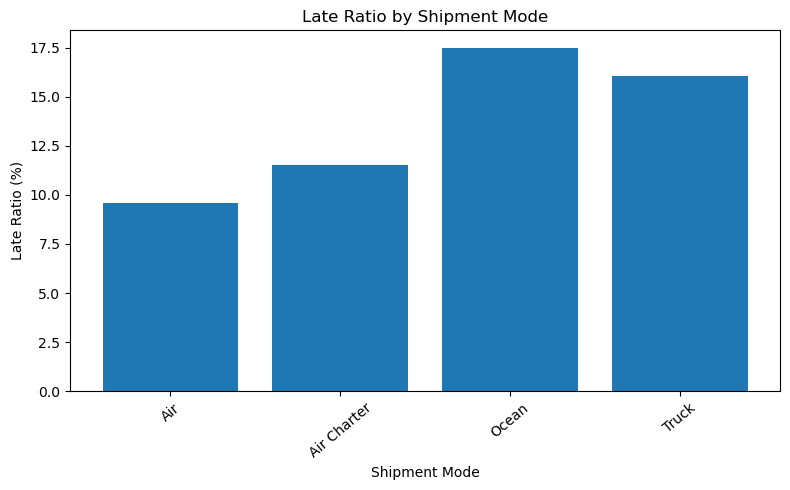

In [52]:
plt.figure(figsize=(8, 5))
plt.bar(shipment_stats["Shipment Mode"], shipment_stats["late_ratio"])
plt.title("Late Ratio by Shipment Mode")
plt.xlabel("Shipment Mode")
plt.ylabel("Late Ratio (%)")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


Monthly Total Quantity over Time

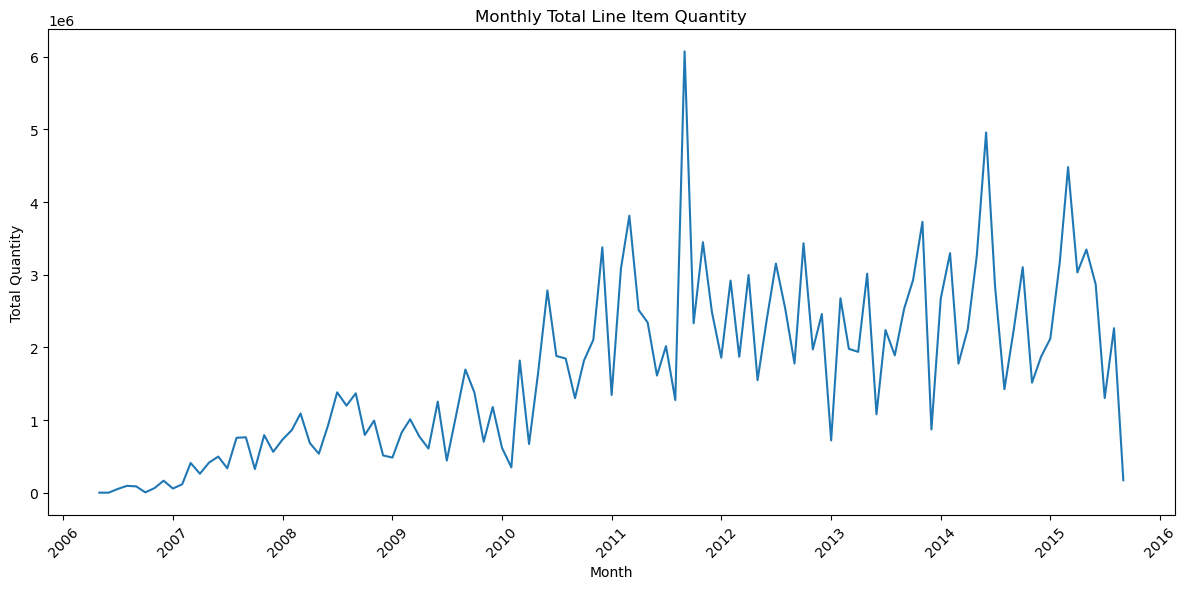

In [53]:
monthly_stats_plot = monthly_stats.copy()
monthly_stats_plot["date"] = pd.to_datetime(monthly_stats_plot["year_month"])

plt.figure(figsize=(12, 6))
plt.plot(monthly_stats_plot["date"], monthly_stats_plot["total_quantity"])
plt.title("Monthly Total Line Item Quantity")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


slice

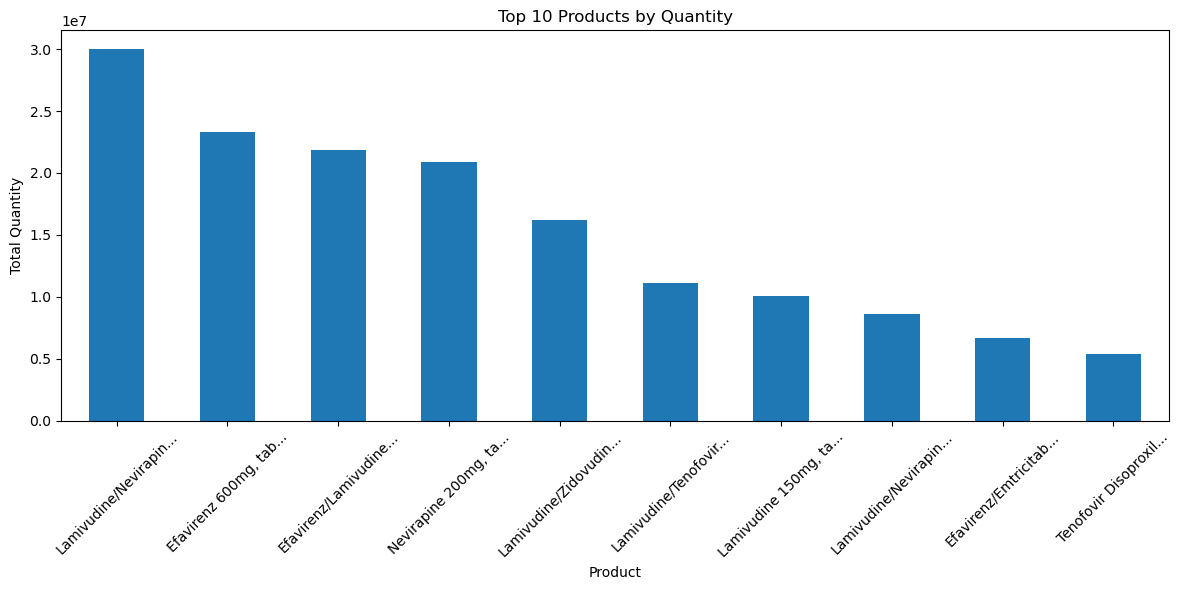

In [54]:
top_products_short = top_products.copy()
top_products_short.index = top_products_short.index.str.slice(0, 20) + "..."

plt.figure(figsize=(12,6))
top_products_short.plot(kind="bar")
plt.title("Top 10 Products by Quantity")
plt.ylabel("Total Quantity")
plt.xlabel("Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ead_time_days

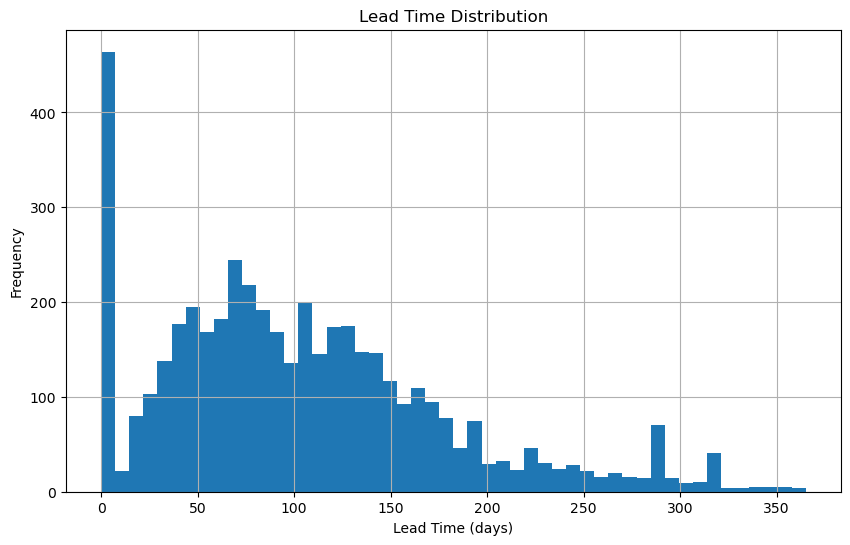

In [55]:
plt.figure(figsize=(10,6))
df["lead_time_days"].hist(bins=50)
plt.title("Lead Time Distribution")
plt.xlabel("Lead Time (days)")
plt.ylabel("Frequency")
plt.show()


Freight Cost

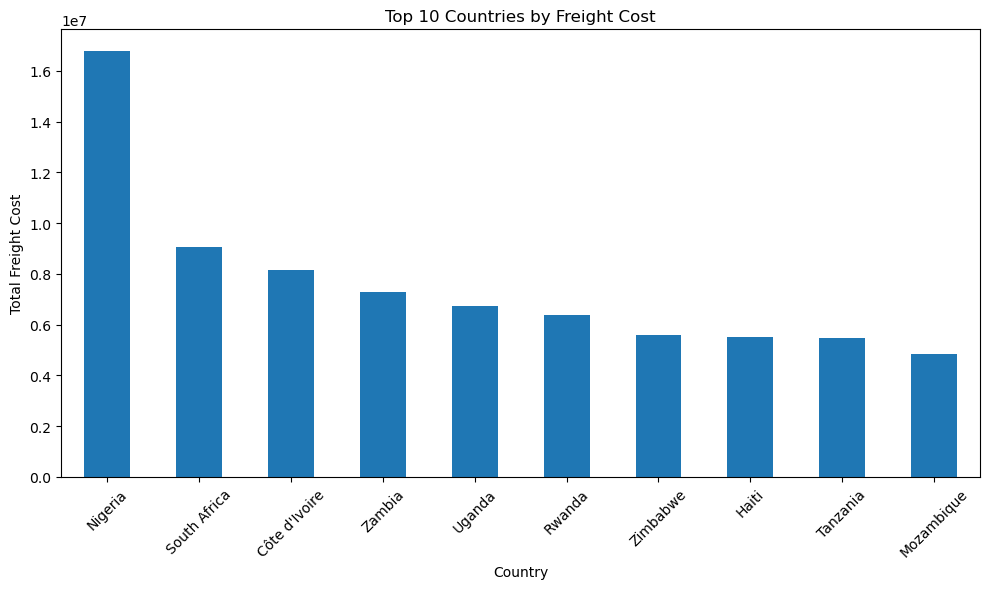

In [56]:
cost_by_country.plot(kind="bar", figsize=(10,6))
plt.title("Top 10 Countries by Freight Cost")
plt.ylabel("Total Freight Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Correlation Matrix

In [59]:
corr_cols = [
    "Line Item Quantity",
    "Line Item Value",
    "Weight (Kilograms)",
    "Freight Cost (USD)",
    "lead_time_days",
    "delay_days"
]

corr_matrix = df[corr_cols].corr()

print(corr_matrix)


                    Line Item Quantity  Line Item Value  Weight (Kilograms)  \
Line Item Quantity            1.000000         0.839081            0.308166   
Line Item Value               0.839081         1.000000            0.310431   
Weight (Kilograms)            0.308166         0.310431            1.000000   
Freight Cost (USD)            0.326986         0.376328            0.245879   
lead_time_days                0.181445         0.136695            0.099514   
delay_days                   -0.053182        -0.044727           -0.021157   

                    Freight Cost (USD)  lead_time_days  delay_days  
Line Item Quantity            0.326986        0.181445   -0.053182  
Line Item Value               0.376328        0.136695   -0.044727  
Weight (Kilograms)            0.245879        0.099514   -0.021157  
Freight Cost (USD)            1.000000        0.000669   -0.015717  
lead_time_days                0.000669        1.000000    0.209033  
delay_days                   -0.

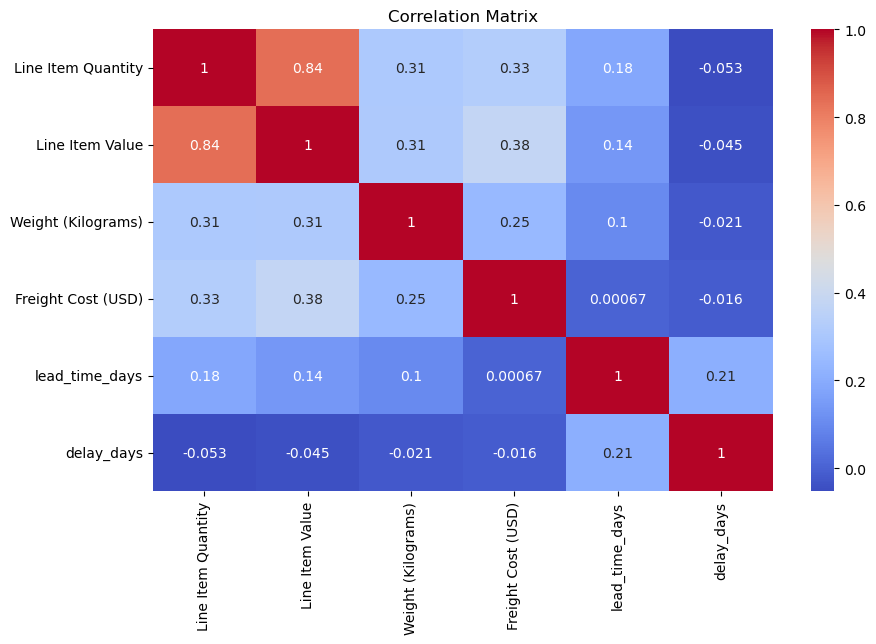

In [60]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [62]:
early_df = df[df["delay_days"] < 0]

early_summary = early_df["delay_days"].describe()
print(early_summary)


count    2590.000000
mean      -22.632432
std        19.898857
min       -89.000000
25%       -31.000000
50%       -17.000000
75%        -8.000000
max        -1.000000
Name: delay_days, dtype: float64


In [64]:
late_df = df[df["delay_days"] > 0]

late_summary = late_df["delay_days"].describe()
print(late_summary)


count    1186.000000
mean       21.369309
std        28.498134
min         1.000000
25%         5.000000
50%        12.000000
75%        24.750000
max       192.000000
Name: delay_days, dtype: float64


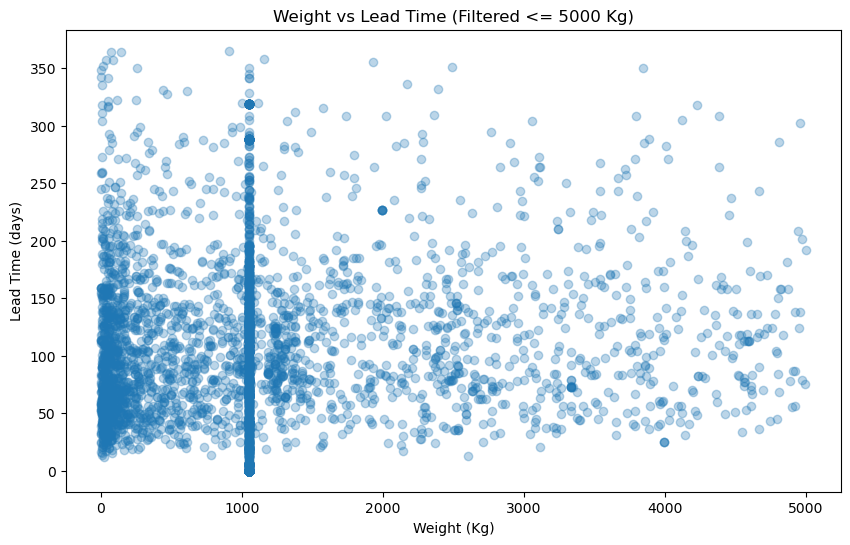

In [77]:
df_filtered = df[df["Weight (Kilograms)"] <= 5000]

plt.figure(figsize=(10,6))
plt.scatter(df_filtered["Weight (Kilograms)"], df_filtered["lead_time_days"], alpha=0.3)
plt.title("Weight vs Lead Time (Filtered <= 5000 Kg)")
plt.xlabel("Weight (Kg)")
plt.ylabel("Lead Time (days)")
plt.show()



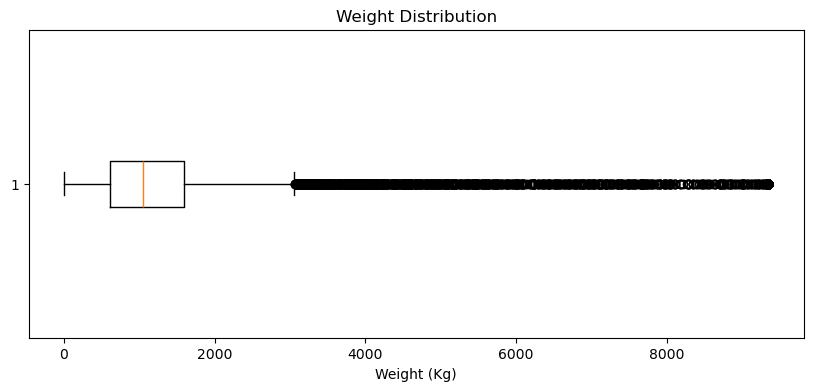

In [76]:
plt.figure(figsize=(10,4))
plt.boxplot(df["Weight (Kilograms)"], vert=False)
plt.title("Weight Distribution")
plt.xlabel("Weight (Kg)")
plt.show()
